In [1]:
import sys
sys.path.append('..')

In [2]:
from tqdm import tqdm
import pandas as pd
import pickle
from scipy.stats import chisquare
from matplotlib import pyplot as plt

In [3]:
from curry.loader import Loader

In [4]:
with open('../data/cache/leifi_enough_text.pkl', 'rb') as f:
    leifi = pickle.load(f)

### Basic Info

In [21]:
pd.DataFrame({
    'berlin': leifi[leifi.land == 'berlin'].groupby('grundwissen_url').klass.unique(),
    'hessen': leifi[leifi.land == 'hessen'].groupby('grundwissen_url').klass.unique()
})

,berlin,hessen
grundwissen_url,,
/akustik/akustische-phaenomene/grundwissen/saitenschwingung,"[5, 6, 9, 10]",[8]
/akustik/akustische-phaenomene/grundwissen/schall-schallquellen-und-schallempfaenger,"[5, 6, 9, 10]",[8]
/akustik/akustische-phaenomene/grundwissen/schwingungen-der-luftsaeule-pfeifen,"[5, 6, 9, 10]",[8]
/akustik/akustische-phaenomene/grundwissen/stehende-wellen-und-eigenschwingungen,"[5, 6, 9, 10]",[8]
/akustik/akustische-phaenomene/grundwissen/toene,"[5, 6, 9, 10]",[8]
...,...,...
/waermelehre/waermetransport/grundwissen/waermeleitung,"[5, 6, 7, 8]",[7]
/waermelehre/waermetransport/grundwissen/waermemitfuehrung,"[5, 6, 7, 8]",[7]
/waermelehre/waermetransport/grundwissen/waermestrahlung-temperaturstrahlung,"[5, 6, 7, 8]",[7]


In [42]:
loader = Loader()

In [5]:
leifi = loader.simple()

In [6]:
leifi.shape

(11667, 7)

In [7]:
leifi.grundwissen_url.nunique()

539

In [8]:
counts_per_state = leifi.land.value_counts().to_frame()
counts_per_state.index = [l.replace('-', ' ').capitalize() for l in counts_per_state.index]
counts_per_state = counts_per_state.reset_index().\
    rename(columns = {'index': 'State', 'land': 'Lesson Count'})
# print(counts_per_state.to_latex())

In [9]:
content_by_url = leifi.groupby('grundwissen_url').content.first()

In [10]:
from curry.clean import Cleaner

In [11]:
cleaner = Cleaner('')

In [14]:
cleaned_contents = [cleaner.clean(c) for c in tqdm(content_by_url)]

100%|███████████████████████████████| 539/539 [02:07<00:00,  4.23it/s]


<AxesSubplot:>

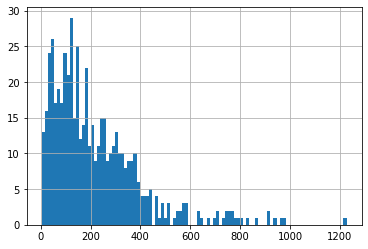

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
tokenizer = vec.build_tokenizer()
word_counts = pd.Series(
    [len(tokenizer(c)) for c in cleaned_contents],
    index=content_by_url.index)
word_counts.hist(bins=100)

In [16]:
word_counts.min(), word_counts.median(), word_counts.max()

(6, 174.0, 1227)

In [17]:
leifi = leifi[
    leifi.grundwissen_url.isin(word_counts[word_counts > 25].index)
]

In [18]:
leifi.shape

(11198, 7)

In [21]:
with open('../data/cache/leifi_enough_text.pkl', 'wb') as f:
    pickle.dump(leifi, f)

### Pre -processing and filtering checkpoint

In [4]:
def agg_land(land_df):
    grade_dist = land_df.klass.value_counts()
    expected = grade_dist.copy()
    expected = grade_dist.mean()
    cs = chisquare(grade_dist, expected)
    return pd.Series({
        'Lowest Grade': land_df.klass.min(),
        'Highest Grade': land_df.klass.max(),
        '# Lessons': land_df.grundwissen_url.nunique(),
        'var': land_df.klass.std(),
        'cs s': cs.statistic,
        'cs p': cs.pvalue
    })

summary = leifi.groupby('land').apply(agg_land)

### Getting Categories

In [186]:
with open('../data/cache/categories_depth_5_v2.pkl', 'rb') as f:
    categories = pickle.load(f)

In [187]:
with open('../data/cache/babelfied.cache', 'rb') as f:
    bab_cache = pickle.load(f)
    
with open('../data/cache/wikified.cache', 'rb') as f:
    wk_cache = pickle.load(f)

In [188]:
wk_urls = []
bab_urls = []

for gu in bab_cache:
    for a in bab_cache[gu]:
        if a.get('DBpediaURL'):
            bab_urls.append(a['DBpediaURL'])
            
for gu in wk_cache:
    for a in wk_cache[gu]['annotations']:
        if a.get('dbPediaIri'):
            wk_urls.append(a['dbPediaIri'])

In [189]:
all_dbpedia_urls = set(bab_urls).union(set(wk_urls))

In [190]:
urls_to_fetch = all_dbpedia_urls.difference(set(categories.keys()))

In [195]:
from curry.km import DBPediaPhysicsResourcesFilter

ImportError: cannot import name 'DBPediaPhysicsResourcesFilter' from 'curry.km' (../curry/km.py)

In [194]:
physics_filter = DBPediaPhysicsResourcesFilter()

NameError: name 'DBPediaPhysicsResourcesFilter' is not defined

### Training

In [4]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [5]:
from curry.model import Trainer, Models

In [6]:
trainer = Trainer('../data/')

In [7]:
from curry.model import Models

In [8]:
test = trainer.train_score(dict(
            land='berlin',
            name='xgbClassifier', 
            vec_type='babelkw',
            vec_type_args=[0.05, True],
            is_coarse=False,
            args=[
                10,
                leifi[leifi.land == 'berlin'].klass.nunique()
            ]
        ))

In [9]:
test[0]

{'confusion_matrix': array([[12,  0,  9,  6, 59, 27,  7,  9],
        [12,  0,  9,  6, 59, 27,  7,  9],
        [12,  0,  4,  8, 53, 15,  4, 13],
        [14,  0, 13,  7, 50, 16,  4, 13],
        [48,  0, 26, 24, 37, 20, 52, 13],
        [48,  0, 26, 24, 38, 19, 52, 13],
        [ 8,  0,  3,  1, 63, 24, 14,  4],
        [ 6,  0,  6,  4, 32, 12,  9, 53]]),
 'accuracy': 0.12559160695099317,
 'approx_accuracy': 0.3517452960032677}

In [64]:
# OG: For different feature types
job_descs = []
for (vec_type, vec_type_args) in \
    (
    [('babelkw', [t,p]) for t in [0.7, 0.8, 0.9, 0.99] for p in [True, False]] + 
     [('wikikw', [t, p]) for t in [0.01, 0.02, 0.05, 0.07, 0.08, 0.1] for p in [True, False]] +
     [(v, []) for v in [
         # 'kw', 
         # 'st', 
         # 'tfidf'
     ]]):
    for land in leifi.land.unique():#[:2]:
        job_descs.append(dict(
            land=land,
            name='xgbClassifier', 
            vec_type=vec_type,
            vec_type_args=vec_type_args,
            args=[
                10,
                leifi[leifi.land==land].klass.nunique()
            ]
        ))

In [14]:
# To Vary Model type
job_descs = []
for (vec_type, vec_type_args, is_coarse) in [
    ('babelkw', [0.7, True], False),
    ('wikikw', [0.01, True], False),
    ('st', [], False),
    ('tfidf', [], False),
    ('kw', [], False)
]:
    for land in leifi.land.unique():
        for (clf, clf_args) in [
            ('xgbClassifier', [10, leifi[leifi.land==land].klass.nunique()]),
            # ('xgbMultilabelClassifer', [10]),
            # ('xgbOrdinalClassifier', [10])
        ]:
            job_descs.append(dict(
                land=land,
                name=clf, 
                vec_type=vec_type,
                vec_type_args=vec_type_args,
                is_coarse=is_coarse,
                args=clf_args
            ))

In [16]:
# All states
job_descs = []
for (vec_type, vec_type_args, is_coarse) in [
    ('babelkw', [0.7, True], True),
    ('wikikw', [0.01, True], True),
    ('st', [], True),
    ('tfidf', [], True),
    ('kw', [], True)
]:
    for (clf, clf_args) in [
        ('xgbClassifier', [10, leifi.klass.nunique()]),
        # ('xgbMultilabelClassifer', [10]),
        # ('xgbOrdinalClassifier', [10])
    ]:
        job_descs.append(dict(
            land=None,
            name=clf, 
            vec_type=vec_type,
            vec_type_args=vec_type_args,
            is_coarse=False,
            args=clf_args
        ))

In [15]:
results = list()


for job_desc in tqdm(job_descs):
    result, _ = trainer.train_score(job_desc)
    results.append((job_desc, result))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [06:10<00:00,  4.63s/it]


In [19]:
for r in results:
    print(r[0]['vec_type'], round(r[1]['accuracy'], 3))

babelkw 0.112
wikikw 0.1
st 0.118
tfidf 0.104
kw 0.104


In [17]:
# For model Extraction 
as_df = []
for (job_desc, result) in results:
    acc = result['accuracy']
    a_acc = result['approx_accuracy']
    model_name = job_desc['name']
    vec_type = job_desc['vec_type']
    is_coarse = job_desc['is_coarse']
    land = job_desc['land']
    as_df.append((model_name, vec_type, land, is_coarse, acc, a_acc))
    
df = pd.DataFrame(as_df, columns=['model', 'vec_type', 'land', 'is_coarse', 'accuracy', 'aa'])
df.groupby(['model', 'vec_type', 'is_coarse'])[['accuracy', 'aa']].mean()


# df.\
#     pivot(index='land', columns='vec_type').transpose().\
#     style.highlight_max(color='lightgreen').highlight_min(color='red')

accuracy        aa
model         vec_type is_coarse                    
xgbClassifier babelkw  False      0.234843  0.455432
              kw       False      0.211555  0.434413
              st       False      0.265195  0.489176
              tfidf    False      0.236752  0.461908
              wikikw   False      0.241953  0.461451

In [82]:
# For Feature Extraction
as_df = []
for (job_desc, result) in results:
    acc = result['accuracy']
    vec_type = job_desc['vec_type']
    vec_spec = ','.join(list(map(str, job_desc['vec_type_args']))) if len(job_desc['vec_type_args']) >= 1 else None
    land = job_desc['land']
    as_df.append((vec_type, vec_spec, land, acc))
    
df = pd.DataFrame(as_df, columns=['vec_type', 'vec_spec', 'land', 'accuracy'])
df.groupby(['vec_type', 'vec_spec']).accuracy.mean()


# df.\
#     pivot(index='land', columns='vec_type').transpose().\
#     style.highlight_max(color='lightgreen').highlight_min(color='red')

vec_type  vec_spec 
babelkw   0.7,True     0.226879
wikikw    0.01,True    0.234179
Name: accuracy, dtype: float64

In [67]:
data = Out[66].copy()


In [73]:
rows = []
for i in data.index:
    val = data[i]
    feature_set, (threshold, is_physics_filtered) = i[0], i[1].split(',')
    threshold = float(threshold)
    is_physics_filtered = is_physics_filtered == 'True'
    rows.append((feature_set, is_physics_filtered, threshold, val))
    
data = pd.DataFrame(rows, columns=['feature_set', 'is_physics_filtered', 'threshold', 'accuracy'])

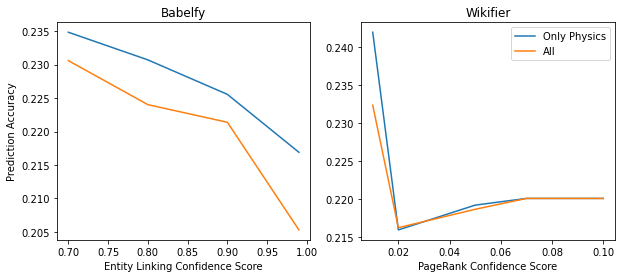

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 4))
s1 = data[(data.feature_set=='babelkw') & data.is_physics_filtered]
s2 = data[(data.feature_set=='babelkw') & ~data.is_physics_filtered]
ax1.plot(s1.threshold, s1.accuracy, label='Only Physics')
ax1.plot(s2.threshold, s2.accuracy, label='All')
ax1.set_title('Babelfy')
ax1.set_ylabel('Prediction Accuracy')
ax1.set_xlabel('Entity Linking Confidence Score')
s3 = data[(data.feature_set=='wikikw') & data.is_physics_filtered]
s4 = data[(data.feature_set=='wikikw') & ~data.is_physics_filtered]
ax2.plot(s3.threshold, s3.accuracy, label='Only Physics')
ax2.plot(s4.threshold, s4.accuracy, label='All')
ax2.set_title('Wikifier')
ax2.set_xlabel('PageRank Confidence Score')
ax2.legend()
plt.savefig('physics_filtering_over_threhsholds.png')

In [63]:
st.mean()

accuracy    0.265195
dtype: float64

In [67]:
sentence_transformer_results= sentence_transformer_results[['land', 'accuracy']].set_index('land')

In [72]:
with open('../results/iwildspaper/sentence_transformer_accuracies_by_state.pkl', 'wb') as f:
    pickle.dump(sentence_transformer_results, f)

In [117]:
with open('../results/iwildspaper/wikikw_accuracies_by_state_threshold.pkl', 'wb') as f:
    pickle.dump(wk.drop(wk.index[80:96]), f)

In [75]:
with open('../results/iwildspaper/babelkw_accuracies_by_state_threshold.pkl', 'wb') as f:
    pickle.dump(babel_results[['vec_spec', 'land', 'accuracy']], f)

### Multi-label

In [46]:
def accuracy(y_pred, y_test, _type):
    correct_count = 0
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, :]
        gt = y_test[i, :]
        labels_correct = 0
        for p, g in zip(pred, gt):
            if _type == 'atleastone':
                if (p == 1) and (g == 1):
                    correct_count += 1
                    break
            elif _type == 'all':
                if p == g:
                    labels_correct += 1
                if labels_correct == y_pred.shape[1]:
                    correct_count += 1
    return correct_count / y_pred.shape[0]

In [51]:
from curry.model import Models
from curry.features import Extractor
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.model_selection import StratifiedKFold
import numpy as np

def onehot(ks):
    out = np.zeros(9)
    for k in ks:
        out[k - 5] = 1
    return out

scores = {}
for vec_type, vec_args in [
    ('babelkw', [0.8, False]),
    ('wikikw', [0.05, False]),
    # ('st', []),
    # ('tfidf', []),
    # ('kw', [])
]:
    scores[vec_type] = {'sep': [], 'agg': None, 'predictions': None}
    predictions = []
    for land in leifi.land.unique():
        extractorC = Extractor('../data/cache/')
        df = leifi[leifi.land == land]
        key_label = df.groupby('grundwissen_url').klass.unique().apply(onehot)
        X, n = extractorC.content_vecs(key_label.index, vec_type, vec_args)
        y = np.stack(key_label.values)

        split_point = int(X.shape[0] * .8) 
        X_train = X[:split_point, :]
        X_test = X[split_point:, :]
        y_train = y[:split_point, :]
        y_test = y[split_point:, :]

        clf = Models.xgbMultilabelClassifer(10)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predictions.append((y_pred, y_test))
        scores[vec_type]['sep'].append(hamming_loss(y_pred, y_test))
    scores[vec_type]['agg'] = np.mean(scores[vec_type]['sep'])
    scores[vec_type]['predictions'] = predictions


In [48]:
with open('../data/cache/mlp_results_1_wikikw_001_true_babel_05_true.pkl', 'wb') as f:
    pickle.dump(scores, f)

In [55]:
for i in scores:
    print(i, scores[i]['agg'])

babelkw 0.20546255827898385
wikikw 0.19371767571400172


In [56]:

for i in scores:
    accs = []
    for y_pred, y_test in scores[i]['predictions']:
        accs.append(accuracy(y_pred, y_test, 'atleastone'))
    print(i, np.mean(accs))

babelkw 0.21330738707692512
wikikw 0.05028582317073171


In [57]:

for i in scores:
    accs = []
    for y_pred, y_test in scores[i]['predictions']:
        accs.append(accuracy(y_pred, y_test, 'all'))
    print(i, np.mean(accs))

babelkw 0.13078499918450195
wikikw 0.04723704268292683


### Comparing results

In [11]:
with open('../results/iwildspaper/sentence_transformer_accuracies_by_state.pkl', 'rb') as f:
    st = pickle.load(f)

In [12]:
with open('../results/iwildspaper/wikikw_accuracies_by_state_threshold.pkl', 'rb') as f:
    wk = pickle.load(f)

In [13]:
with open('../results/iwildspaper/babelkw_accuracies_by_state_threshold.pkl', 'rb') as f:
    bl = pickle.load(f)


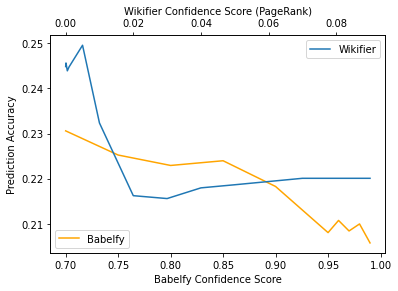

In [59]:
data_bl = bl.groupby('vec_spec').accuracy.mean()
data_wk = wk.groupby('vec_spec').accuracy.mean()
fig, ax = plt.subplots(1,1)
ax2 = ax.twiny()
ax.plot(data_bl.index, data_bl.values, label='Babelfy', color='orange')
ax2.plot(data_wk.index, data_wk.values, label='Wikifier')
ax.set_xlabel('Babelfy Confidence Score')
ax2.set_xlabel('Wikifier Confidence Score (PageRank)')
ax.set_ylabel('Prediction Accuracy')
ax.legend(loc=3)
ax2.legend(loc=1)
plt.savefig('entity_linking_performance_w_confidence.png')

In [27]:
st.mean()

accuracy    0.265195
dtype: float64

In [26]:
wk.groupby('vec_spec').accuracy.mean()

vec_spec
0.00001    0.244862
0.00010    0.245659
0.00050    0.243915
0.00100    0.244765
0.00500    0.249592
0.01000    0.232347
0.02000    0.216221
0.03000    0.215580
0.04000    0.217952
0.05000    0.218642
0.07000    0.220073
0.08000    0.220073
0.09000    0.220073
Name: accuracy, dtype: float64

In [123]:
bl.pivot(index='land', columns='vec_spec').\
    style.highlight_max(color='lightgreen').highlight_min(color='red')

In [124]:
leifi.groupby

,accuracy
land,
baden-wuerttemberg,0.183590
bayern,0.375493
berlin,0.125567
brandenburg,0.207529
bremen,0.305097
hamburg,0.229651
hessen,0.420952
mecklenburg-vorpommern,0.363226
nordrhein-westfalen,0.200252


In [83]:
bl.join(st, on='land', rsuffix='bl', lsuffix='st')

,vec_spec,land,accuracyst,accuracybl
0,0.70,baden-wuerttemberg,0.152011,0.183590
1,0.70,bayern,0.278635,0.375493
2,0.70,berlin,0.126451,0.125567
3,0.70,brandenburg,0.196172,0.207529
4,0.70,bremen,0.253367,0.305097
...,...,...,...,...
155,0.99,sachsen-anhalt,0.218019,0.250073
156,0.99,schleswig-holstein,0.157895,0.212476
157,0.99,thueringen,0.199233,0.253587
158,0.99,niedersachsen,0.159605,0.207627


### Features across grades

In [15]:
from curry.features import Extractor
import numpy as np
import json
import urllib

In [6]:
extractorC = Extractor('../data/cache/')

In [7]:
urls = leifi.grundwissen_url.unique()

In [8]:
def get_simple_feature(babel_feature):
    try:
        f = json.loads(babel_feature)
    except Exception as e:
        print(e)
        return None
    if f['dbpedia']:
        return urllib.parse.unquote(f['dbpedia'][0].split('/')[-1])
    else:
        return urllib.parse.unquote(f['text'][0])


In [16]:
comp = pd.read_pickle('../data/cache/top_features_for_comparison.pkl')
results = {'yake': [], 'babel': [], 'wiki': []}
classes_by_url = leifi.groupby('grundwissen_url').klass.unique()
class_counts = leifi.klass.value_counts().sort_index().values
for extractor in results.keys():
    by_class_feature_count = dict()
    if extractor == 'yake':
        (encoding, feature_names), features = extractorC.keywords(urls), comp.YAKE
    elif extractor == 'babel':
        (encoding, feature_names), features = extractorC.babelfy_kws(urls, 0.5, False), comp.Babelfy
        feature_names = np.array([get_simple_feature(f) for f in feature_names])
    elif extractor == 'wiki':
        (encoding, feature_names), features = extractorC.wikifier_kws(urls, 0.01, False), comp.Wikifier
    for feature in features:
        out = np.zeros(9)
        for url in classes_by_url.index:
            x = np.where(urls == url)
            y = np.where(feature_names == feature)
            feature_count = encoding[x, y].todense()
            try:
                feature_count = feature_count.item()
            except Exception as e:
                print(x, y, extractor, feature, url)
                raise e
            for klass in classes_by_url[url]:
                out[klass - 5] += feature_count
        results[extractor].append((feature, np.divide(out, class_counts)))

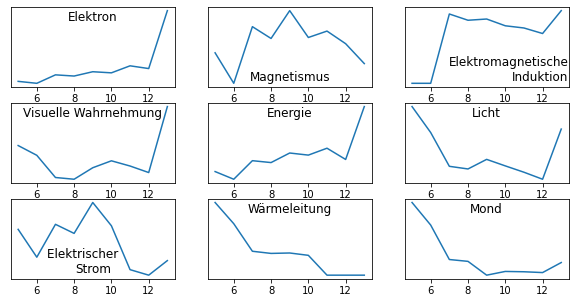

In [52]:
fig, axs = plt.subplots(3, 3, figsize=(10,5))
extractor == 'wiki'
for i in range(3):
    for j in range(3):
        feature, result = results[extractor][i*3+j]
        axs[j][i].plot(list(range(5, 14)), result)
        if feature == 'Elektron':
            axs[j][i].set_title(feature, y=1.0, pad=-14)
        elif feature == 'Magnetismus':
            axs[j][i].set_title(feature, y=1.0, pad=-74)
        elif feature.startswith('Elektro'):
            axs[j][i].set_title(feature.replace(' ', '\n'), y=1.0, pad=-74, loc='right')
        elif feature.startswith('Elektri'):
            axs[j][i].set_title('Elektrischer     \nStrom', y=1.0, pad=-74, loc='center')
        else:
            axs[j][i].set_title(feature, y=1.0, pad=-14)
        # axs[j][i].set_xticks([])
        axs[j][i].set_yticks([])

# for i, feature in enumerate(by_class_feature_count):
#     if i < 10:
#         axs[i].plot(list(range(5, 14)), by_class_feature_count[feature])
#         axs[i].set_title(feature)

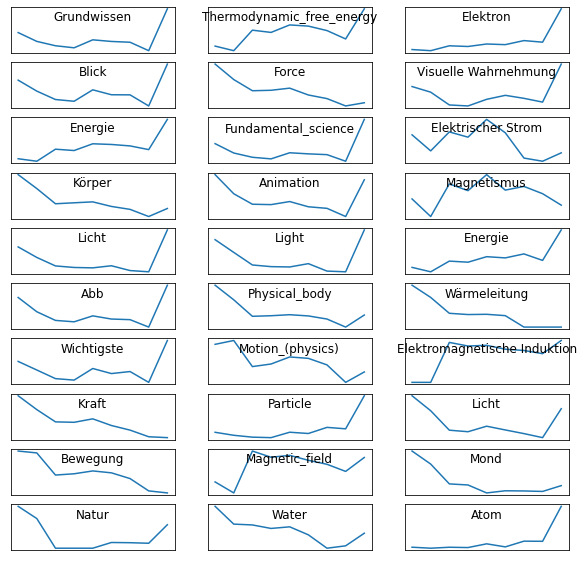

In [185]:
fig, axs = plt.subplots(10, 3, figsize=(10,10))
extractors = list(results.keys())
for i in range(3):
    extractor = extractors[i]
    for j in range(10):
        feature, result = results[extractor][j]
        axs[j][i].plot(list(range(5, 14)), result)
        axs[j][i].set_title(feature, y=1.0, pad=-14)
        axs[j][i].set_xticks([])
        axs[j][i].set_yticks([])

# for i, feature in enumerate(by_class_feature_count):
#     if i < 10:
#         axs[i].plot(list(range(5, 14)), by_class_feature_count[feature])
#         axs[i].set_title(feature)

In [176]:
from PIL import Image

In [179]:
img = Image.open('/home/rsebastian/Downloads/feature_distribution.png')

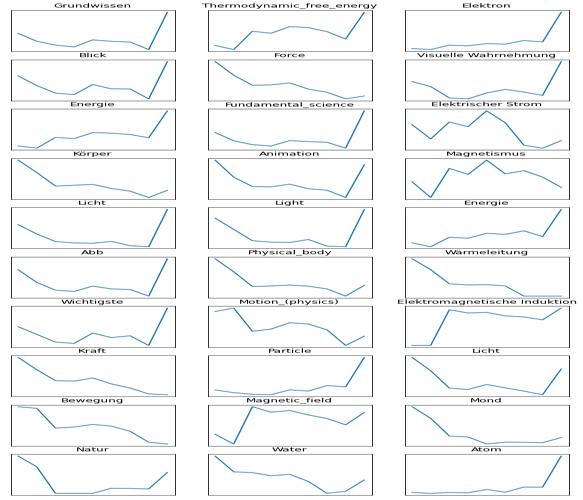

In [182]:
img.resize((583, 500))

In [145]:
comp = pd.read_pickle('../data/cache/top_features_for_comparison.pkl')

In [139]:
comp.loc[10, 'Babelfy'] = '{"dbpedia": [], "text": ["verschiedenen"]}'

In [140]:
comp.to_pickle('../data/cache/top_features_for_comparison.pkl')